In [145]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Input, Dropout
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate

In [146]:
working_dir = os.getcwd()
windowsize = 4
epochs = 100

In [147]:
def read_training_data():
    df = pd.read_csv(f"{working_dir}/../data/TrainData.csv", sep=',')
    windspeed_training = df["WS10"].to_numpy().reshape((-1, 1))
    power_training = df["POWER"].to_numpy()
    u = df["U10"].to_numpy()
    v = df["V10"].to_numpy()
    wind_direction_training = np.mod(180 + np.rad2deg(np.arctan2(v, u)), 360)

    return windspeed_training, power_training, wind_direction_training


def read_input_data():
    df = pd.read_csv(f"{working_dir}/../data/WeatherForecastInput.csv", sep=',')
    windspeed_input = df["WS10"].to_numpy().reshape((-1, 1))
    u_input = df["U10"].to_numpy()
    v_input = df["V10"].to_numpy()
    direction_input = np.mod(180 + np.rad2deg(np.arctan2(v_input, u_input)), 360).reshape((-1, 1))
    windspeed_and_direction_input = np.concatenate((windspeed_input, direction_input), axis=1)

    return windspeed_input, direction_input, windspeed_and_direction_input

def read_solution():
    df = pd.read_csv(f"{working_dir}/../data/Solution.csv", sep=',')
    actual_power = df["POWER"].to_numpy()
    timestamp = df["TIMESTAMP"].to_numpy()

    return actual_power, timestamp

In [148]:
def create_timeseries(powers, windowsize):
    rows = len(powers) - windowsize
    x = np.zeros((rows, windowsize))
    y = np.zeros(rows)

    for i in range(rows):
        x[i] = powers[i:i + windowsize]
        y[i] = powers[i + windowsize]

    return x, y

In [149]:
training_data = read_training_data()
windspeed_training = training_data[0]
power_training = training_data[1]

input_data = read_input_data()
windspeed_input = input_data[0]
wind_direction = input_data[1]
windspeed_and_direction_input = input_data[2]

solution = read_solution()
actual_power = solution[0]
timestamp = solution[1]

In [150]:
x, y = create_timeseries(power_training, windowsize)
forecast_input = create_timeseries(actual_power, windowsize)[0]

In [159]:
def regression(x, y, model, forecast_input, actual_power, windowsize):
    # Train model
    model.fit(x, y)
    # Predict using trained model
    y_pred = model.predict(forecast_input)

    # Calculate RMSE
    power_comparison = actual_power[windowsize:]
    rmse = np.sqrt(mean_squared_error(power_comparison, y_pred))

    # Return the results of RMSE and the predicted power
    return y_pred, rmse

In [160]:
def ann_model(x, y, forecast_input, actual_power, windowsize, epochs):
    scaler_y = MinMaxScaler()
    y = scaler_y.fit_transform(y.reshape(-1, 1))

    # Create Model

    model = Sequential()
    model.add(Input(shape=(windowsize,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    # model.add(Dense(100, activation='relu'))
    model.add(Dense(1))


    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    # Train model
    model.fit(x, y, epochs=epochs, batch_size=32)

    # Predict using trained model
    y_pred_scaled = model.predict(forecast_input)

    y_pred_ann = scaler_y.inverse_transform(y_pred_scaled)

    # Calculate RMSE
    power_comparison = actual_power[windowsize:].reshape(-1, 1)

    rmse = np.sqrt(mean_squared_error(power_comparison, y_pred_scaled))

    return y_pred_ann, rmse

In [161]:
def rnn_model(x, y, forecast_input, actual_power, windowsize, epochs):
    # Process Variables
    x = x.reshape(-1, 1, windowsize)

    input_data = forecast_input.reshape(len(forecast_input), 1, windowsize)

    # Create Model
    model = Sequential()
    model.add(LSTM(32, input_shape=(1, windowsize), activation='relu', return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(64, activation='relu'))
    model.add(Dropout(0.1))
    # model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(
        loss='mean_squared_error',
        optimizer='rmsprop',
        metrics=['mean_squared_error'],
    )

     # Train model
    model.fit(x, y, epochs=epochs, batch_size=32)

    # Predict using trained model
    y_pred_rnn = model.predict(input_data)

    # Calculate RMSE
    power_comparison = actual_power[windowsize:]
    rmse = np.sqrt(mean_squared_error(power_comparison, y_pred_rnn))

    return y_pred_rnn, rmse

In [162]:
# Regressions
lr = regression(x, y, LinearRegression(), forecast_input, actual_power, windowsize)
svr = regression(x, y, SVR(), forecast_input, actual_power, windowsize)

# Neural Networks
ann = ann_model(x, y, forecast_input, actual_power, windowsize, epochs)
rnn = rnn_model(x, y, forecast_input, actual_power, windowsize, epochs)

# Print results
print(f"{'RMSE for LR model:':<20}{lr[1]}")
print(f"{'RMSE for SVR model:':<20}{svr[1]}")
print(f"{'RMSE for ANN model:':<20}{ann[1]}")
print(f"{'RMSE for RNN model:':<20}{rnn[1]}")

Epoch 1/100
503/503 [==============================] - 1s 656us/step - loss: 0.0195 - root_mean_squared_error: 0.1395
Epoch 2/100
503/503 [==============================] - 0s 610us/step - loss: 0.0107 - root_mean_squared_error: 0.1036
Epoch 3/100
503/503 [==============================] - 0s 591us/step - loss: 0.0108 - root_mean_squared_error: 0.1041
Epoch 4/100
503/503 [==============================] - 0s 588us/step - loss: 0.0107 - root_mean_squared_error: 0.1036
Epoch 5/100
503/503 [==============================] - 0s 591us/step - loss: 0.0107 - root_mean_squared_error: 0.1033
Epoch 6/100
503/503 [==============================] - 0s 592us/step - loss: 0.0107 - root_mean_squared_error: 0.1037
Epoch 7/100
503/503 [==============================] - 0s 607us/step - loss: 0.0106 - root_mean_squared_error: 0.1031
Epoch 8/100
503/503 [==============================] - 0s 588us/step - loss: 0.0106 - root_mean_squared_error: 0.1031
Epoch 9/100
503/503 [==============================] - 0

In [163]:
# # Save Results to Files
# forecast_template = pd.read_csv(f'{working_dir}/../data/ForecastTemplate.csv')

# # LR forecast template output
print(lr[0].shape)
# forecast_template['FORECAST'] = lr[0]
# forecast_template.to_csv(f'{working_dir}/results/ForecastTemplate3-LR.csv', index=False)

# # SVR forecast template
print(svr[0].shape)
# forecast_template['FORECAST'] = svr[0]
# forecast_template.to_csv(f'{working_dir}/results/ForecastTemplate3-SVR.csv', index=False)

# # ANN forecast template
print(ann[0].shape)
# forecast_template['FORECAST'] = ann[0]
# forecast_template.to_csv(f'{working_dir}/results/ForecastTemplate3-ANN.csv', index=False)

# # RNN forecast template
print(rnn[0].shape)
# forecast_template['FORECAST'] = rnn[0]
# forecast_template.to_csv(f'{working_dir}/results/ForecastTemplate3-RNN.csv', index=False)

(716,)
(716,)
(716, 1)
(716, 1)


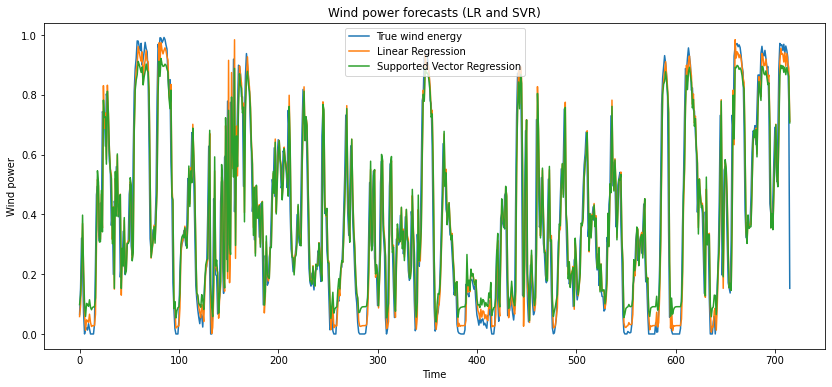

In [164]:
# Plot the time-series figure for LR and SVR
plt.figure(figsize=(14, 6))
plt.plot(actual_power[windowsize:], label="True wind energy")
plt.plot(lr[0], label="Linear Regression")
plt.plot(svr[0], label="Supported Vector Regression")
plt.xlabel("Time")
plt.ylabel("Wind power")
plt.title("Wind power forecasts (LR and SVR)")
plt.legend()
plt.show()

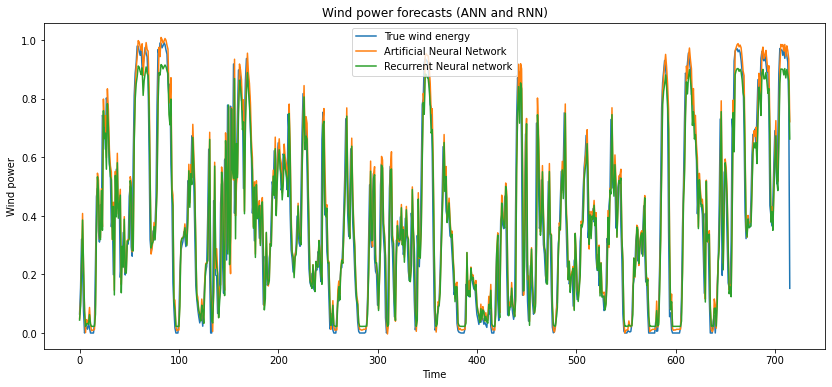

In [165]:
# Plot the time-series figure for ANN and RNN
plt.figure(figsize=(14, 6))
plt.plot(actual_power[windowsize:], label="True wind energy")
plt.plot(ann[0], label="Artificial Neural Network")
plt.plot(rnn[0], label="Recurrent Neural network")
plt.xlabel("Time")
plt.ylabel("Wind power")
plt.title("Wind power forecasts (ANN and RNN)")
plt.legend()
plt.show()

In [166]:
# Table for Results
table_data = [lr[0], svr[0], ann[0], rnn[0]]
headers = ["lr", "svr", "ann", "rnn"]
table = tabulate(table_data, headers=headers, tablefmt="pretty")
print(table)

+----------------------+---------------------+---------------------+--------------------+---------------------+---------------------+----------------------+---------------------+----------------------+---------------------+---------------------+---------------------+---------------------+---------------------+----------------------+----------------------+---------------------+--------------------+--------------------+---------------------+---------------------+---------------------+---------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+---------------------+---------------------+--------------------+---------------------+--------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+------------------

C:\Users\marti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tabulate\__init__.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  (len(row) >= 1 and row[0] == SEPARATING_LINE)
C:\Users\marti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tabulate\__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
